In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import emcee
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'

In [2]:
from models_EF import *

In [3]:
#background = np.loadtxt('data/O_cen_data_Bck_no_events.txt',usecols=(1),unpack=True)[:7]
#background = np.loadtxt('back_events.txt',usecols=(1),unpack=True)

In [4]:
print len(background)

7


In [5]:
#Ener,no_events,el,er = np.loadtxt('number_of_events.txt',unpack=True)
Ener,no_events,el,er = np.loadtxt('data/OC_no_events_9_bins.txt',usecols=(0,1,2,3),unpack=True)

In [6]:
#Ener,no_events,el,er = np.loadtxt('data/O_cen_data_no_events.txt',usecols=(0,1,2,3),unpack=True)

In [7]:
#Ener,no_events,el,er = Ener[:7],no_events[:7],el[:7],er[:7]

In [8]:
mask = no_events != 0.0

In [9]:
Ener = Ener[mask]
no_events = no_events[mask]
el = el[mask]
er = er[mask]

In [10]:
print len(no_events), len(background)

7 7


In [11]:
print no_events

[152. 135. 130. 132.  95.  23.   8.]


In [12]:
#no_events = no_events - background

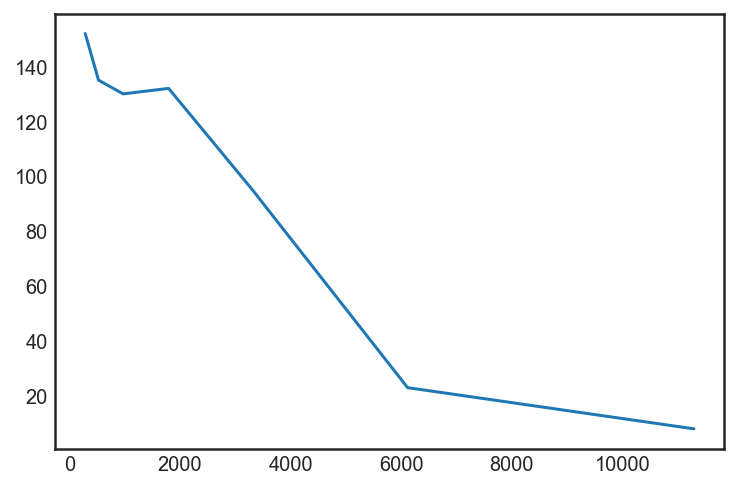

In [13]:
plt.plot(Ener,no_events);

In [14]:
print Ener[0]

284.6876220703125


In [15]:
e_min = Ener - el
e_max = Ener + er

In [16]:
print e_min
print e_max

[ 200.          369.37524414  682.19030762 1259.92102051 2326.91821289
 4297.52929688 7937.00537109]
[  369.37524414   682.19030762  1259.92102051  2326.91821289
  4297.52929688  7937.00537109 14658.66601562]


In [17]:
from scipy import optimize as op

In [18]:
fun2 = lambda *args: -event_lnhood(*args)

In [19]:
mid_2 = [1.5,0.5,3.2,-9.,-6.,1.5]
bnds_2 = ((.01,3.), (0.1,3.), (3.0,3.4),(-14.,-6.),(-15.,0.),(0.,3.))

In [20]:
print no_events_logparabola(mid_2,e_min,e_max)

[  3156.40627581  18442.53852513  61244.18560294 110704.79034038
 104419.17858796  55148.55234908  18273.05292956]


In [21]:
print event_lnhood(mid_2,no_events,e_min,e_max,'logpar',None,None,None)

-366993.9853899176


In [22]:
result2 = op.minimize(fun2, mid_2, args=(no_events,e_min,e_max,'logpar',None,None,None),method = 'TNC',bounds=bnds_2)

In [23]:
print result2.x

[  1.37734795   0.84155057   3.22769634 -12.70465867  -6.00100852
   1.58474124]


In [24]:
p_list_2 = [.01,3., .1,3., 3.,3.4, -14.,-6.,-15.,0.,0.,3.]

In [25]:
nwalkers = 480
ndim = (len(p_list_2)/2) 

In [26]:
print ndim

6


In [27]:
z = np.zeros((ndim,nwalkers))

In [28]:
h = 1e-4

pos_i=[]


for i in range(ndim):
    z[i,:] = result2.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i],z[4,i],z[5,i]]))

In [29]:
b_steps, steps = 200, 1000

In [30]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,event_lnpost, 
                                args=(no_events,e_min,e_max,'logpar',p_list_2,None,None,None),
                                threads = 2)

In [31]:
pos,prob,state=sampler.run_mcmc(pos_i, b_steps)

In [32]:
print sampler.acceptance_fraction.mean()

0.48021874999999997


In [33]:
sampler.reset()

In [34]:
_,_,_=sampler.run_mcmc(pos, steps, rstate0=state)

In [35]:
print sampler.acceptance_fraction.mean()

0.41945208333333334


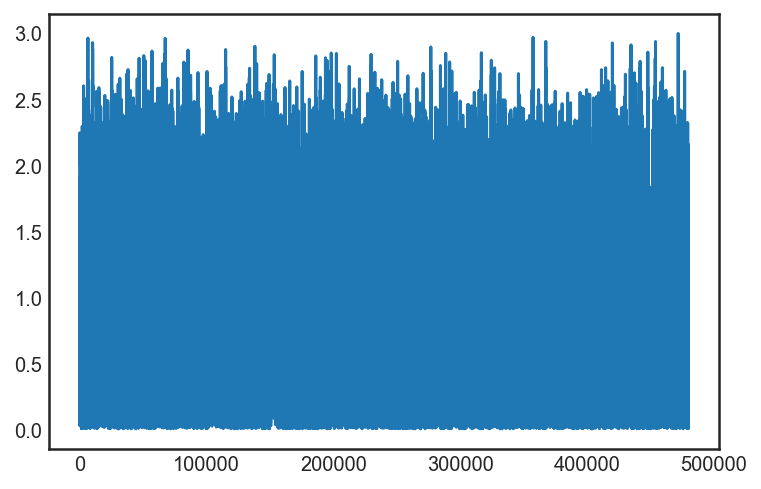

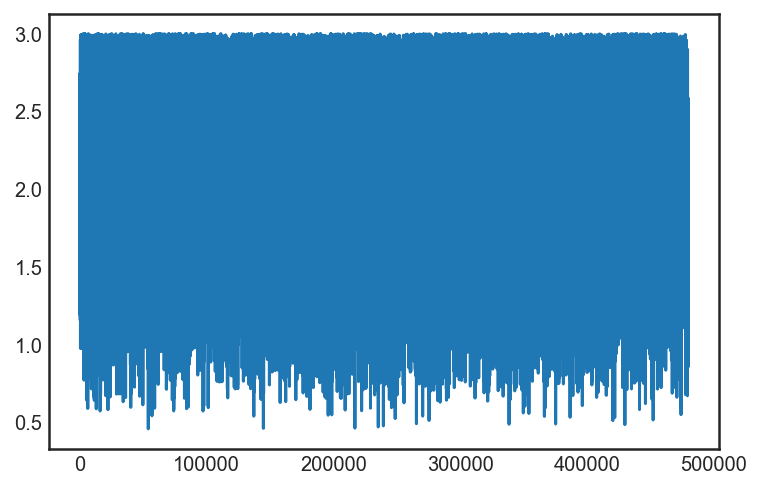

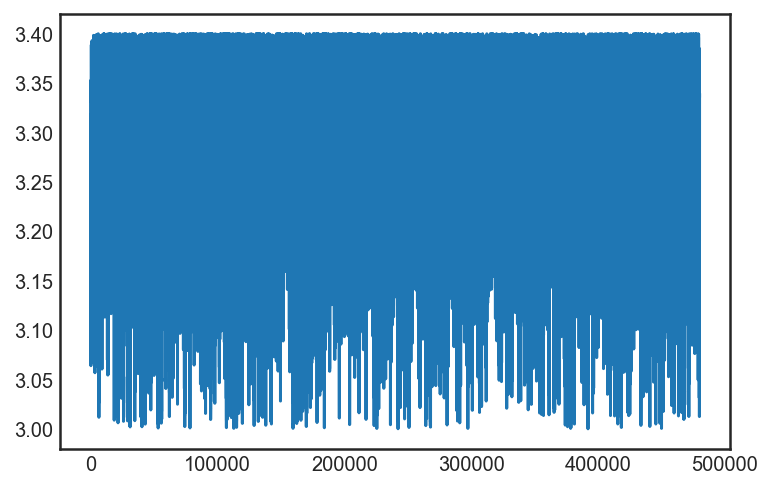

In [36]:
plt.figure()
plt.plot(sampler.flatchain[:,0]);
plt.figure()
plt.plot(sampler.flatchain[:,1]);
plt.figure()
plt.plot(sampler.flatchain[:,2]);

In [37]:
import corner as corner 

In [38]:
labels = [r'$\alpha_{oc}$',r'$\beta$',r'$log10(E_p)$',r'$log10(N)$',r'$log10(N_s)$',r'$\alpha$']

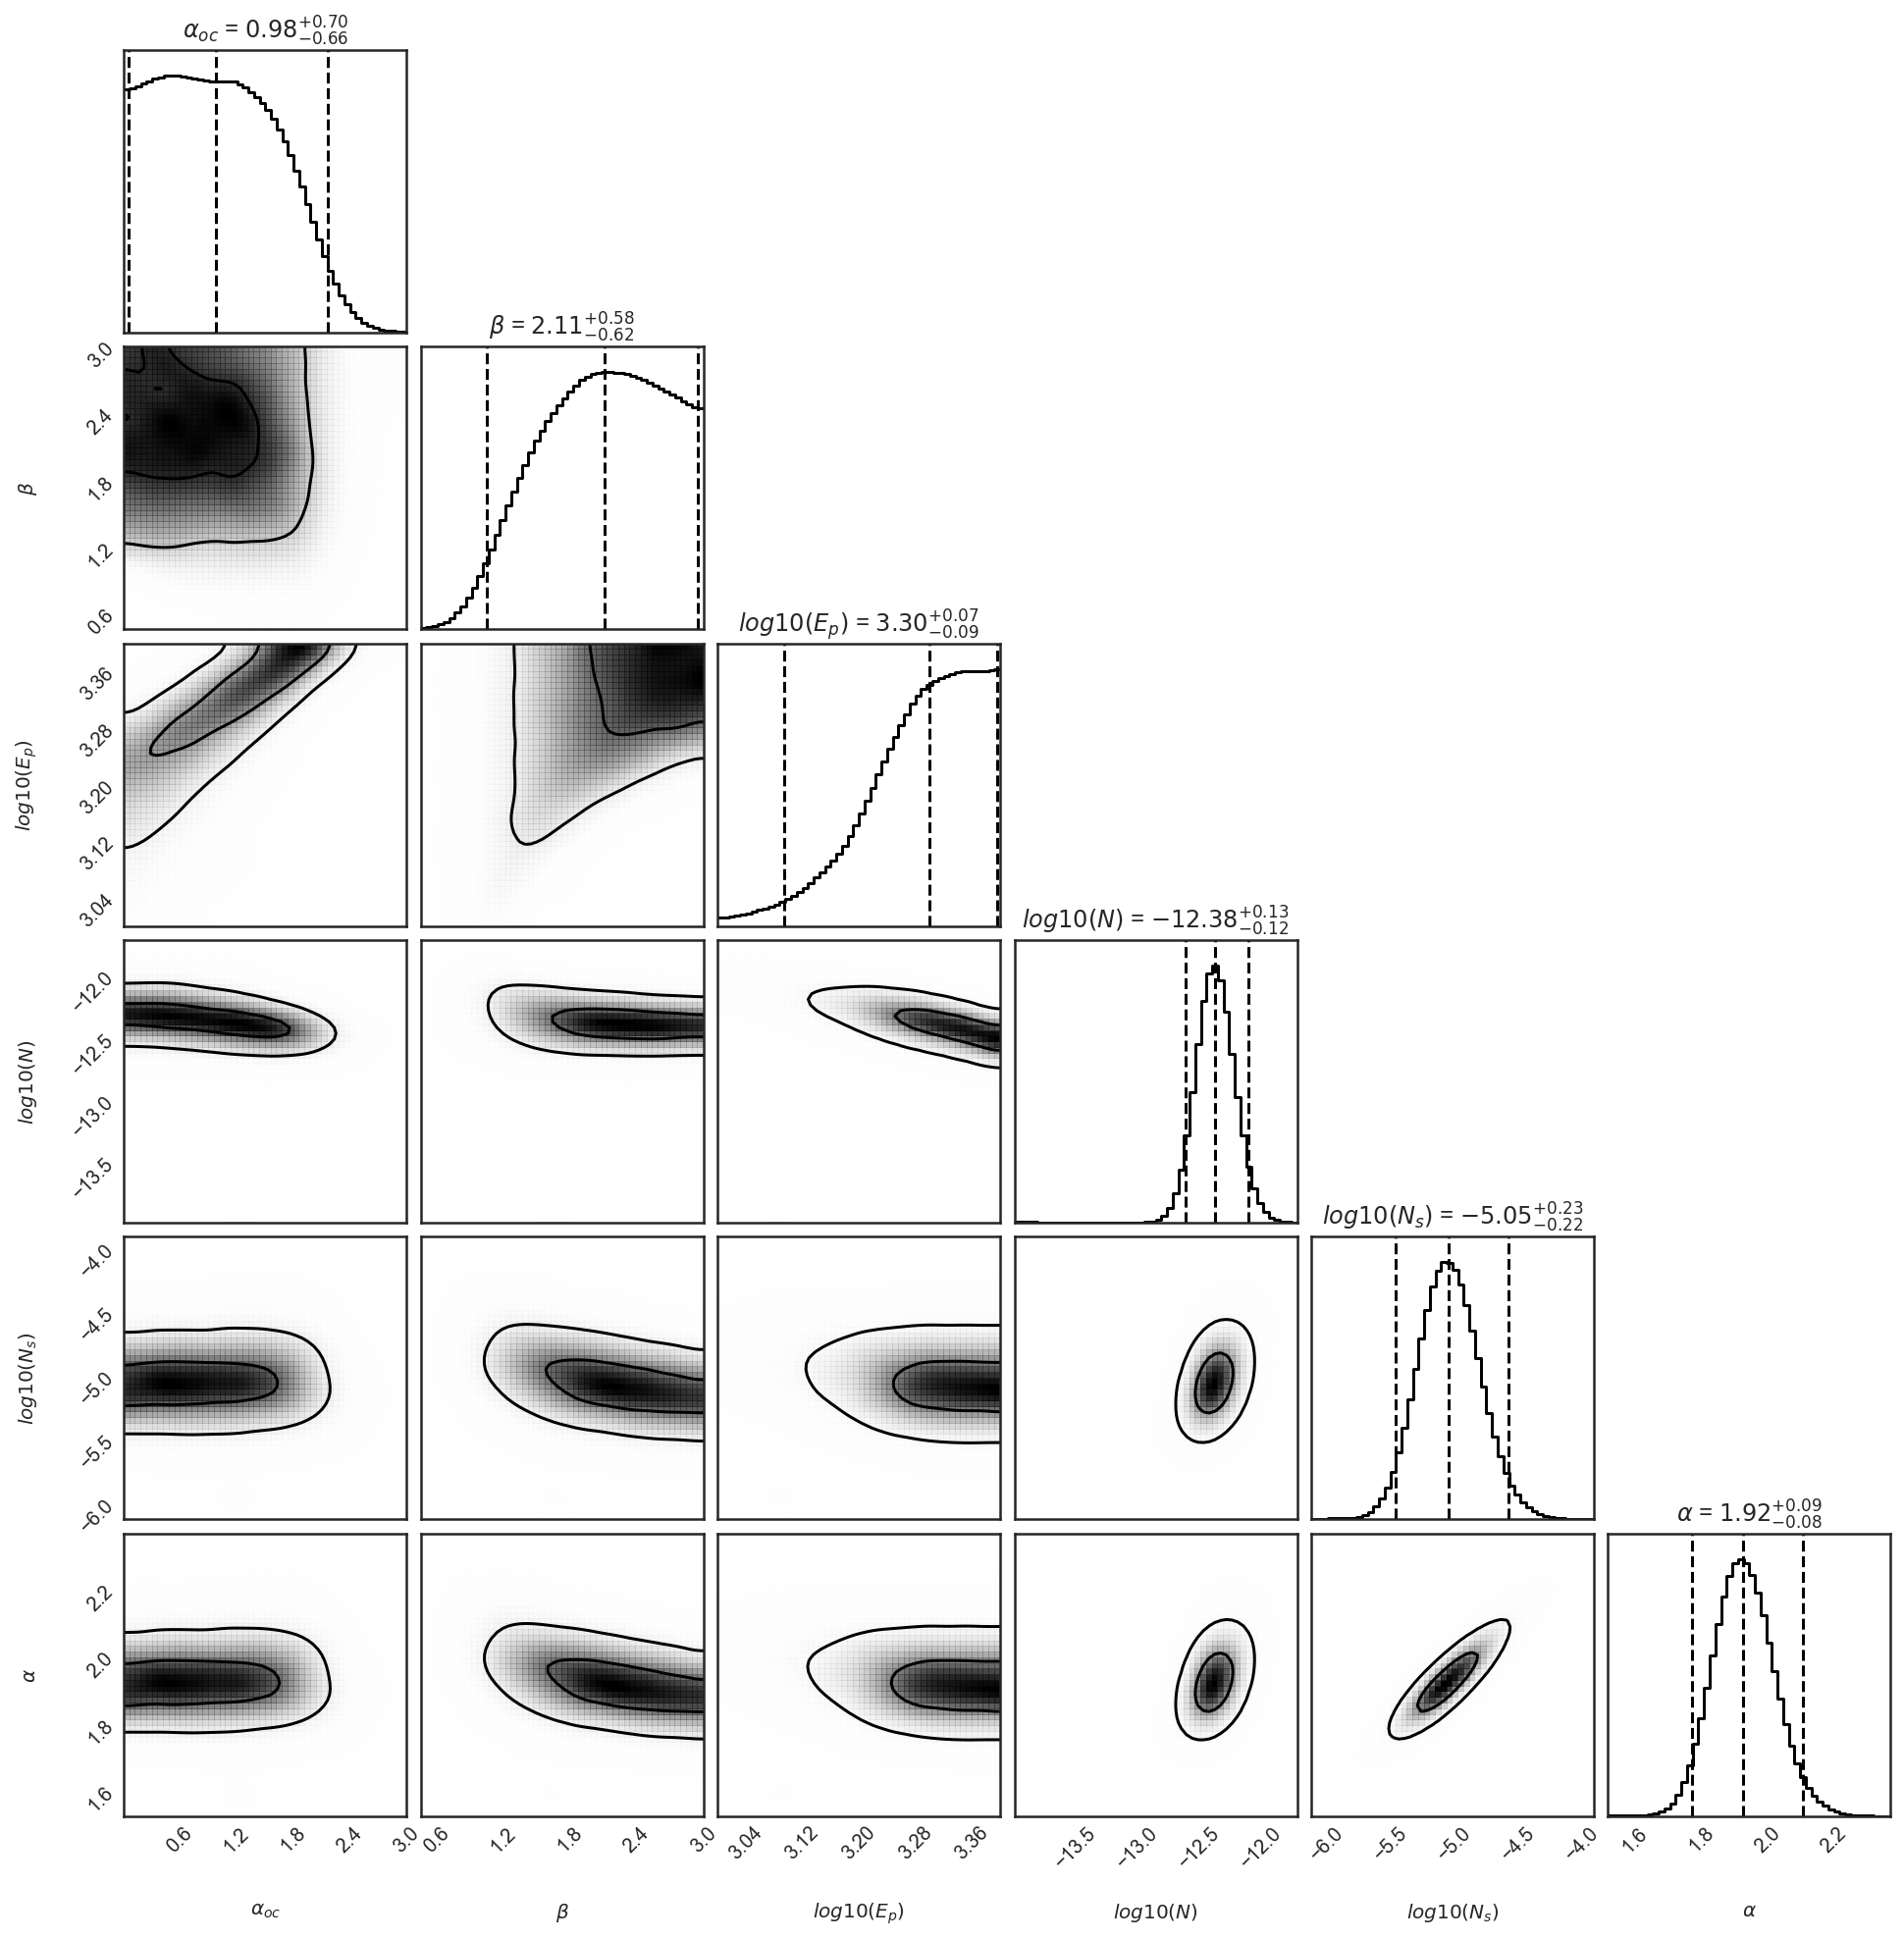

In [39]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [40]:
fig.savefig('data/data9_bin_logpar_Ep34.pdf')

In [41]:
events = no_events_model_pulsar([0.7,np.log10(2500.),1.4],e_min,e_max)

In [42]:
print events

[4.45365376e+11 1.67125457e+12 4.61895650e+12 8.61007838e+12
 9.28314607e+12 5.08320017e+12 1.13048949e+12]


In [43]:
10.**3.37

2344.228815319923

In [44]:
np.savetxt('chains/chains9_bin_logpar_Ep34',sampler.flatchain)

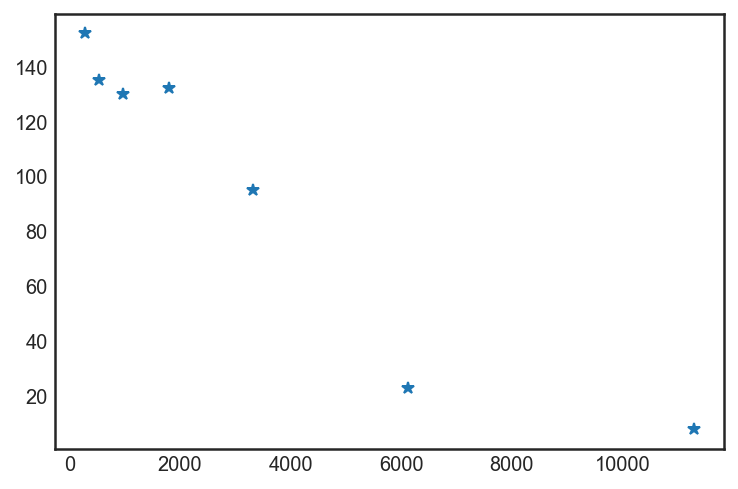

In [45]:
plt.plot(Ener,no_events,'*');

In [46]:
#events_wo_back= np.loadtxt('number_of_events_bck.txt',usecols=1,unpack=True)

Text(0,0.5,u'No_Events')

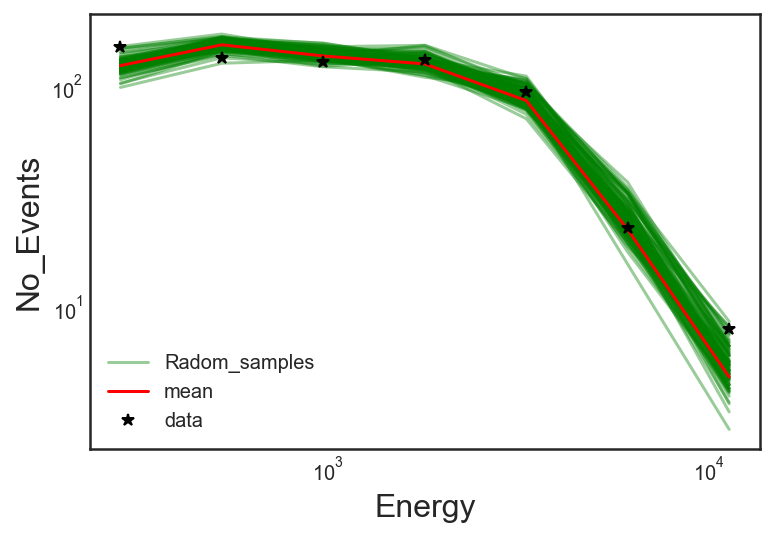

In [47]:
fig1 = plt.figure()

for c1,c2,c3,c4,c5,c6 in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=100)]:
    val_1 = no_events_logparabola([c1,c2,c3,c4,c5,c6],e_min,e_max)
    fig_1,=plt.loglog(Ener,val_1,'g',alpha=0.4);

val1_mean = no_events_logparabola([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2]),
                                   np.mean(sampler.flatchain[:,3]),np.mean(sampler.flatchain[:,4]),np.mean(sampler.flatchain[:,5])],e_min,e_max)

fig_2,=plt.loglog(Ener,val1_mean,'r');
#fig_2,=plt.plot(Ener,no_events_model_pulsar([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])],e_min,e_max)+ background);
#plt.plot(Ener,no_events,'*b');
fig_3,=plt.loglog(Ener,no_events,'*k');
plt.legend([fig_1,fig_2,fig_3],['Radom_samples','mean','data'],loc='best')
plt.xlabel('Energy',fontsize=16)
plt.ylabel('No_Events',fontsize=16)
#plt.plot(Ener,no_events_model_pulsar([-0.23,3.14,-1.18],e_min,e_max),'b');

fig1.savefig('data/results_25bins.pdf')

In [48]:
print no_events_logparabola([np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2]),np.mean(sampler.flatchain[:,3]),
                            np.mean(sampler.flatchain[:,4]),np.mean(sampler.flatchain[:,5])],e_min,e_max)

[125.11228513 155.38697421 138.31534271 127.27771005  86.83470112
  22.58784058   4.84552286]


In [49]:
print no_events_model_pulsar([-.6,3.9,-2.29],e_min,e_max)

[1.48736139e+11 1.31980987e+12 9.09295832e+12 4.65083688e+13
 1.63425831e+14 3.94270223e+14 6.43304502e+14]


In [50]:
np.mean(sampler.flatchain[:,0]),np.mean(sampler.flatchain[:,1]),np.mean(sampler.flatchain[:,2])

(1.0098362378607402, 2.090234535632044, 3.2872911132473295)

In [51]:
print e_min

[ 200.          369.37524414  682.19030762 1259.92102051 2326.91821289
 4297.52929688 7937.00537109]


In [52]:
print e_max

[  369.37524414   682.19030762  1259.92102051  2326.91821289
  4297.52929688  7937.00537109 14658.66601562]


In [53]:
print background

[0.03358128 0.02399209 0.01450675 0.0072111  0.00315503 0.00130474
 0.00058988]


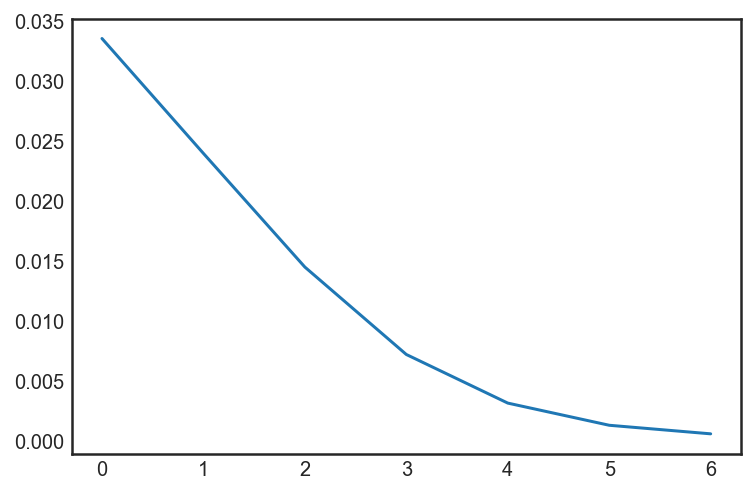

In [54]:
plt.plot(background)